<a href="https://colab.research.google.com/github/luvbenz/2025-CV/blob/main/2-10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving Fig0943(a)(dark_blobs_on_light_background).tif to Fig0943(a)(dark_blobs_on_light_background) (51).tif


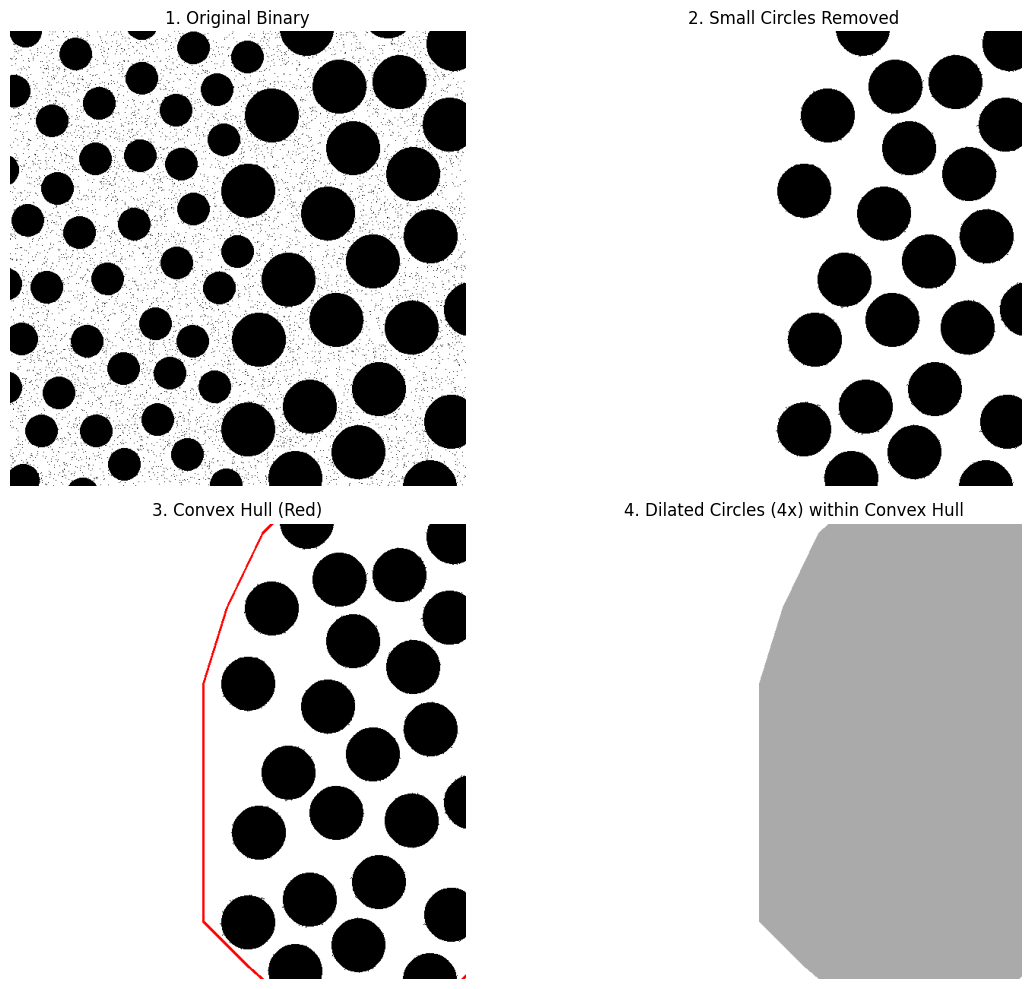

In [19]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from google.colab import files

# 1. 이미지 업로드 및 불러오기
uploaded = files.upload()
img_path = list(uploaded.keys())[0]
img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)

# 2. Otsu 이진화 + 반전
_, binary = cv.threshold(img, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
inv = cv.bitwise_not(binary)

# 3. Connected Components 분석
num_labels, labels, stats, centroids_all = cv.connectedComponentsWithStats(inv)

# 4. 큰 원 추출
min_area_large = 1500
filtered = np.zeros_like(inv)
centroids = []
radii = []

for i in range(1, num_labels):
    area = stats[i, cv.CC_STAT_AREA]
    if area >= min_area_large:
        filtered[labels == i] = 255
        yx = np.column_stack(np.where(labels == i))
        centroid = np.mean(yx, axis=0)
        centroids.append(centroid[::-1])  # (x, y)
        radii.append(np.sqrt(area / np.pi))  # 원 반지름 추정

# 5. Convex Hull을 위한 padding 점 확장
padding = int(np.mean(radii)) + 25 if radii else 30
expanded_points = []
for pt in centroids:
    x, y = pt
    expanded_points.extend([
        [x + padding, y],
        [x - padding, y],
        [x, y + padding],
        [x, y - padding],
    ])
expanded_points = np.array(expanded_points).astype(np.int32)

# 6. Convex Hull 생성
if len(expanded_points) >= 3:
    hull = cv.convexHull(expanded_points.reshape(-1, 1, 2)).reshape(-1, 2)
else:
    hull = None

hull_mask = np.zeros_like(inv)
if hull is not None:
    cv.drawContours(hull_mask, [hull], 0, 255, -1)

# 7. 원 전체 마스크 생성
original_circles = np.zeros_like(inv)
for i in range(1, num_labels):
    area = stats[i, cv.CC_STAT_AREA]
    if area >= min_area_large:
        original_circles[labels == i] = 255

# 8. 팽창 커널 생성
avg_radius = int(np.mean(radii)) if radii else 20
kernel_size = avg_radius * 3 * 3
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (kernel_size, kernel_size))

# 9. dilation 적용 후 Convex Hull 내부로 제한
dilated = cv.dilate(original_circles, kernel, iterations=1)
dilated_limited = cv.bitwise_and(dilated, hull_mask)

# 10. 시각화용 이미지들 생성
image_step1 = binary.copy()  # 1단계: 원본 이진화
image_step2 = cv.bitwise_not(filtered)  # 2단계: 작은 원 제거

# 3단계: Convex Hull 테두리 표시
hull_overlay = cv.cvtColor(cv.bitwise_not(filtered), cv.COLOR_GRAY2BGR)
if hull is not None:
    cv.drawContours(hull_overlay, [hull], 0, (0, 0, 255), 2)

# 4단계: 팽창 결과 적용
output_img_dilate = cv.cvtColor(np.full_like(inv, 255), cv.COLOR_GRAY2BGR)
output_img_dilate[dilated_limited == 255] = (170, 170, 170)
image_step4 = output_img_dilate.copy()

# 11. 최종 4단계 시각화
titles = [
    '1. Original Binary',
    '2. Small Circles Removed',
    '3. Convex Hull (Red)',
    '4. Dilated Circles (4x) within Convex Hull'
]
images = [
    image_step1,
    image_step2,
    hull_overlay,
    image_step4
]

plt.figure(figsize=(12, 10))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    if images[i].ndim == 2:
        plt.imshow(images[i], cmap='gray')
    else:
        plt.imshow(cv.cvtColor(images[i], cv.COLOR_BGR2RGB))
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()
